<a href="https://colab.research.google.com/github/Adrianosh3/NeuronaleNetze/blob/Finale-Codes-zum-Dr%C3%BCberschaun/CNN_from_SCRATCH_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Verbindung zu Google Drive herstellen

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Pakete importieren

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

import os
import copy
import glob
import time
from pathlib import Path

import PIL
from PIL import Image


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [ ]:
#GPU verwenden

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.10.0+cu111  Device: cuda


In [ ]:
#Parameter definieren

Number_Hidden_Neurons = 80
Number_Hidden_Neurons_2 = 100    
num_classes = 2
BATCH_SIZE = 32
in_channels = 3
Learning_Rate = 0.01
Number_Epochs = 16
classes = ('Cat', 'Dog')

In [ ]:
#Daten aus ZIP-File laden

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/NN_SS2021/dogs-vs-cats.zip') as entire_zip:
     entire_zip.extractall('.')
with zipfile.ZipFile('./train.zip') as train_zip:
     train_zip.extractall('.')

train_dir = './train'

In [ ]:
#Daten splitten

def extract_class_from(path):
    file = path.split('/')[-1]
    return file.split('.')[0]

In [ ]:
#Daten labeln

class DogVsCatDataset(Dataset):
  
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
  
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
       
        img_name = self.file_list[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
    
        label_category = extract_class_from(img_name)
        label = 1 if label_category == 'dog' else 0
    
        return image, label

In [ ]:
class Dogs_CatsDataset(Dataset):

    def __init__(self, root, image_dir, csv_file, transform=None):
        self.root = root
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.data = pd.read_csv(csv_file).iloc[:, 1]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_name = os.path.join(self.image_dir, self.image_files[index])  
        image = PIL.Image.open(image_name)
        label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return (image, label)

In [ ]:
Img_dir = glob.glob(os.path.join(train_dir, '*.jpg'))
x_train ,x_test = train_test_split(Img_dir,test_size=0.2,random_state=42)   #Image Split: Teilen 

In [ ]:
#Training- und Testdaten aufbereiten

image_dir = '/content/drive/MyDrive/NN_SS2021/dogs-vs-cats/train/train/'
csv_file = '/content/drive/MyDrive/NN_SS2021/dogs-vs-cats/train/dogs_cats.csv'

transform_test = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                               ])

transform_Val = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                               ])

x_train ,x_test = train_test_split(Img_dir,test_size=0.2)

train_dataset  = DogVsCatDataset(x_train, transform= transform_test)
validation_dataset = DogVsCatDataset(x_test, transform= transform_Val)

print('Anzahl Daten: ',len(Img_dir))
print('Anzahl Train_Daten: ',len(train_dataset))
print('Anzahl Test_Daten: ',len(validation_dataset))

Anzahl Daten:  25000
Anzahl Train_Daten:  20000
Anzahl Test_Daten:  5000


In [ ]:
#Train- und Testloader

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('Anzahl train_loader: ',len(train_loader))
print('Anzahl test_loader: ',len(validation_loader))

Anzahl train_loader:  625
Anzahl test_loader:  157


In [ ]:
#Dimension anzeigen lassen

for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for images, labels in validation_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])


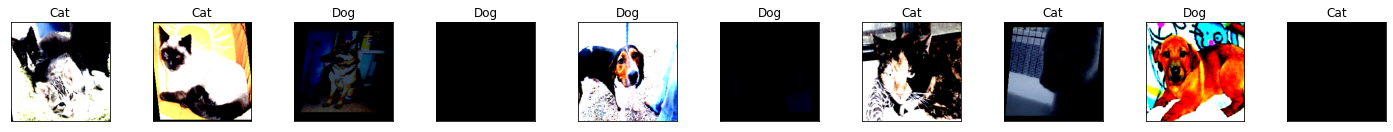

In [ ]:
#Einige Bilder beider Klassen anzeigen

def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [ ]:
#Struktur des Modells

class CNN_Modell(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(CNN_Modell, self).__init__()
        
        #Feature Learning

        self.features = nn.Sequential(

            #Schicht 1
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            #Schicht 2           
            nn.Conv2d(6, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            #Schicht 3         
            nn.Conv2d(10, 15, kernel_size=6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            #Schicht 4           
            nn.Conv2d(15, 20, kernel_size=9),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            #Schicht 5           
            nn.Conv2d(20, 25, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) 
        )
#Classification

        self.classifier = nn.Sequential(
            
            #Hidden Layer 1
            nn.Linear(3*3*25, Number_Hidden_Neurons),
            nn.ReLU(),
            nn.Dropout(0.5),

            #Hidden Layer 2
            nn.Linear(Number_Hidden_Neurons, Number_Hidden_Neurons_2),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            #Output Layer
            nn.Linear(Number_Hidden_Neurons_2, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return probas

In [ ]:
#Modell laden

model_cnn = CNN_Modell(in_channels, num_classes).to(device)
model_cnn

CNN_Modell(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(10, 15, kernel_size=(6, 6), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(15, 20, kernel_size=(9, 9), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(20, 25, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=225, out_features=80, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(i

In [ ]:
from torchsummary import summary
summary (model_cnn, (3, 224, 224))

In [ ]:
#Loss Function vorgeben 
criterion = nn.CrossEntropyLoss()

#Optimizer vorgeben 
optimizer = torch.optim.SGD(model_cnn.parameters(), lr = Learning_Rate, momentum=0.9)

In [ ]:
## Trainings- und Validierungsfunktion

def train_val(epoch, train_loss_history,train_corrects_history,val_loss_history,val_corrects_history):
    train_loss = 0.0
    train_corrects = 0.0
    val_loss = 0.0
    val_corrects = 0.0

    since = time.time()
    best_acc = 0.0
    
    best_model_wts = copy.deepcopy(model_cnn.state_dict())
    model_cnn.train()
        
    # Loop over each batch from the training set
    for batch_idx, (X_train, y_train) in enumerate(train_loader):

        # Copy data to GPU if needed
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward Propagation
        y_predicted = model_cnn(X_train)
      
        # Zero gradient buffers
        optimizer.zero_grad() 

        # Calculate loss
        loss = criterion(y_predicted, y_train)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        _, preds = torch.max(y_predicted, 1)
        train_loss += loss.item()
        train_corrects += torch.sum(preds == y_train.data)
        
    else:
        with torch.no_grad():
          for  X_val, y_val in validation_loader:
           

            X_val = X_val.to(device)
            y_val = y_val.to(device)
            val_outputs = model_cnn(X_val)

            val_loss = criterion(val_outputs, y_val)

            _, val_preds = torch.max(val_outputs, 1)
            val_loss += val_loss.item()
            val_corrects += torch.sum(val_preds == y_val.data)

        epoch_loss = train_loss/len(train_loader.dataset)
        epoch_acc = train_corrects.float()/ len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_corrects_history.append(epoch_acc)

        val_epoch_loss = val_loss/len(validation_loader.dataset)
        val_epoch_acc = val_corrects.float()/ len(validation_loader.dataset)

        if val_epoch_acc > best_acc:
          best_acc = val_epoch_acc
          best_model_wts = copy.deepcopy(model_cnn.state_dict())

        val_loss_history.append(val_epoch_loss)
        val_corrects_history.append(val_epoch_acc)
        print('epoch :', (epoch+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item())) 

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        model_cnn.load_state_dict(best_model_wts)

In [ ]:
#Ausführung des Prozesses

train_loss_history = []
train_corrects_history = []
val_loss_history = []
val_corrects_history = []
#Number_Epochs=20
for epoch in range(Number_Epochs):
    train_val(epoch,train_loss_history,train_corrects_history,val_loss_history,val_corrects_history)

epoch : 1
training loss: 0.0217, acc 0.5010 
validation loss: 0.0003, validation acc 0.4980 
Training complete in 3m 50s
Best val Acc: 0.498000
epoch : 2
training loss: 0.0217, acc 0.5039 
validation loss: 0.0003, validation acc 0.4986 
Training complete in 3m 49s
Best val Acc: 0.498600
epoch : 3
training loss: 0.0216, acc 0.5195 
validation loss: 0.0003, validation acc 0.5458 
Training complete in 3m 49s
Best val Acc: 0.545800
epoch : 4
training loss: 0.0215, acc 0.5397 
validation loss: 0.0003, validation acc 0.6274 
Training complete in 3m 48s
Best val Acc: 0.627400
epoch : 5
training loss: 0.0211, acc 0.5792 
validation loss: 0.0003, validation acc 0.6548 
Training complete in 3m 50s
Best val Acc: 0.654800
epoch : 6
training loss: 0.0205, acc 0.6183 
validation loss: 0.0002, validation acc 0.6772 
Training complete in 3m 51s
Best val Acc: 0.677200
epoch : 7
training loss: 0.0199, acc 0.6378 
validation loss: 0.0003, validation acc 0.7054 
Training complete in 3m 50s
Best val Acc: 0

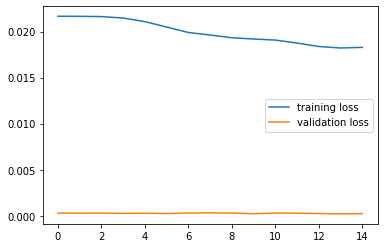

In [ ]:
#Loss-Funktion plotten

plt.plot(train_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/NN_SS2021/CNN_Model_mit_Dropout/Train_Val_Loss2.png')

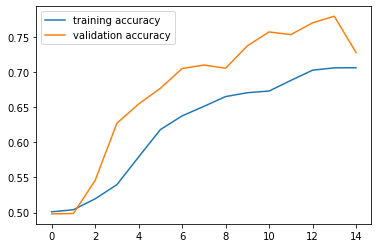

In [ ]:
#Accuracy plotten

plt.plot(train_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/NN_SS2021/CNN_Model_mit_Dropout/Train_Val_Acc2.png')

In [ ]:
#Berechnung der Confusion Matrix

from sklearn.metrics import confusion_matrix

x_test,y_test = next(iter(validation_loader))
y_pred = model_cnn(x_test.to(device))
y_test = y_test.to('cpu')
y=y_pred.data.max(1)[1].to('cpu')
Conf_Mat = confusion_matrix(y,y_test)

for i in range(len(validation_loader)-1):
    x_test,y_test = next(iter(validation_loader))
    y_pred = model_cnn(x_test.to(device))
    y_test = y_test.to('cpu')
    y=y_pred.data.max(1)[1].to('cpu')
    Conf_Mat += confusion_matrix(y,y_test)

Conf_Mat

array([[1552,  346],
       [ 960, 2166]])

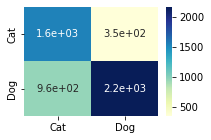

In [ ]:
#Plotten der berechneten Confusion Matrix

import seaborn as sn
df_cm = pd.DataFrame(Conf_Mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (3,2))
sn.heatmap(df_cm,cmap="YlGnBu",annot=True)#,fmt='.2%')
plt.savefig('/content/drive/MyDrive/NN_SS2021/CNN_Model/Train.png')